/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Norm stats (-1.91135353278434e-09, 2.2298898012116754e-05)
torch.Size([2, 15, 120, 120])


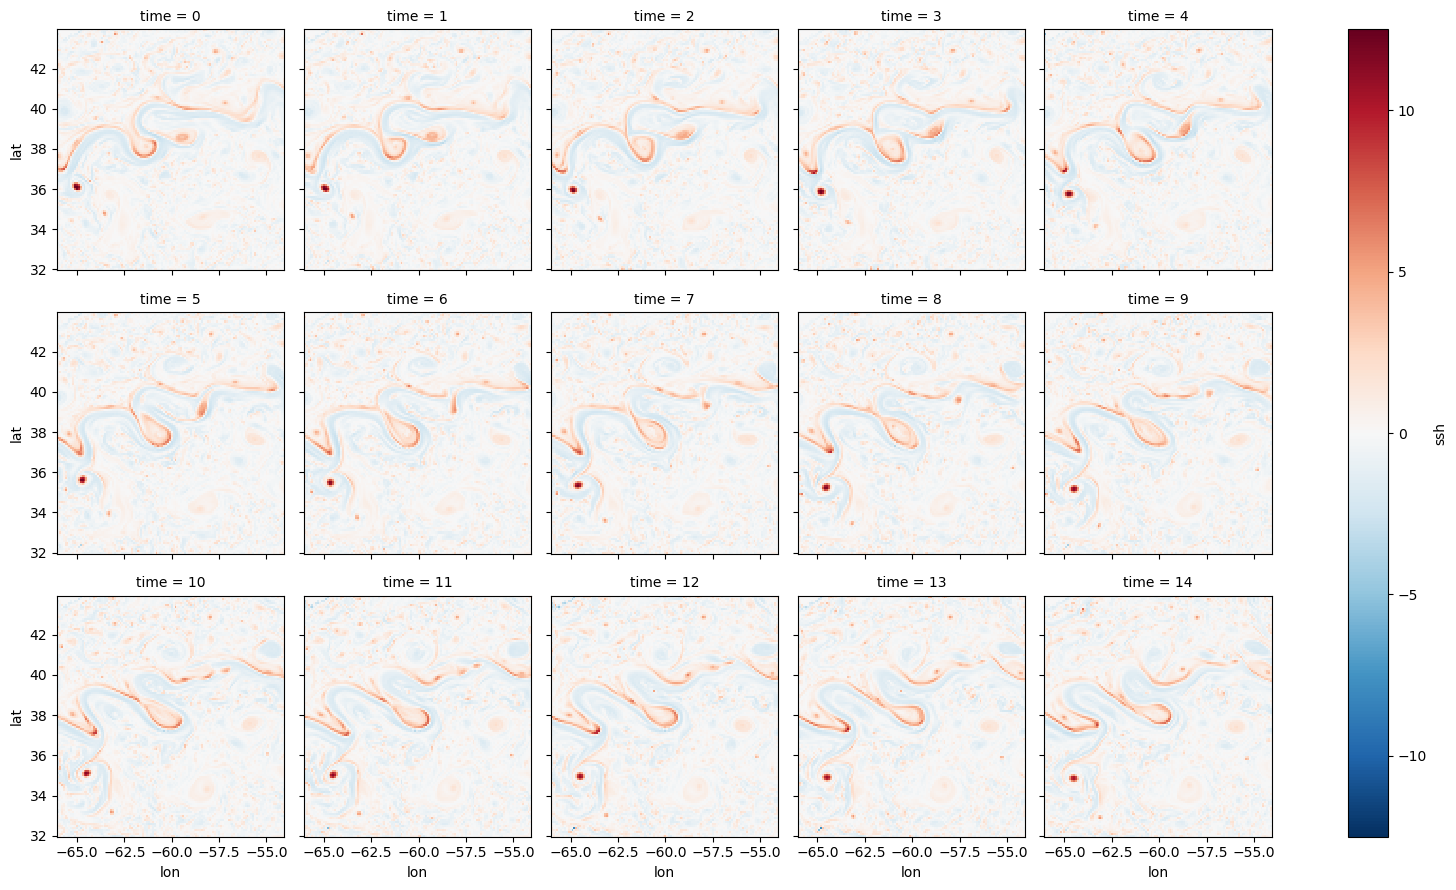

In [1]:
import sys
sys.path.append('..')
from src.data_notebook import *
from src.utils import *
from src.models import *
from contrib.stoch_spde.lit_model_spde import *
from contrib.stoch_spde.models_spde import *
from contrib.stoch_spde.solver import *
#from contrib.stoch_spde.unet import *

def spspmm(A,B):
    return torch.sparse.mm(A,B)

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66 
lon_max = -54
#lon_max = -63
lat_min = 32
lat_max = 44
#lat_max = 35


datamodule = BaseDataModule(input_da=load_altimetry_data("/DATASET/mbeauchamp/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-17', '2012-12-07',)}},
                            xrds_kw={'patch_dims': {'time': 15, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 120, 'lon': 120},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2, grad=True)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(15),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

In [5]:
device = 'cuda'

# state + param
crop_daw = 10
solver = GradSolver_Lgv(aug_state=True,
                      n_step=5,
                      lr_grad=1e-3,
                      exclude_params=False,
                      nll = NLL(shape_data=[datamodule.xrds_kw['patch_dims']['time']-2*crop_daw,120,120],
                                    st_lag=[1,1,1],
                                    pow=2./2, spde_type="adv_diff", 
                                    scheme="FUDM1", downsamp=None, crop=None),#10),
                      nlpobs = NLpObs(),
                      prior_cost=None,
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=9*(datamodule.xrds_kw['patch_dims']['time']-2*crop_daw),
                                                   dim_hidden=244),
                      unet_prior = False).to(device)

# state only
solver2 = GradSolver(n_step=15,
                     lr_grad=1e-3,
                      prior_cost = BilinAEPriorCost(dim_in=15,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=15,dim_hidden=96)).to(device)

# Training (disjoint)

In [9]:
rec_weight1 = get_triang_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
rec_weight1 = torch.from_numpy(rec_weight1).to(device)


rec_weight = get_triang_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time']-2*crop_daw,
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

downsamp = 4
down = torch.nn.AvgPool2d(downsamp)
up = torch.nn.UpsamplingBilinear2d(scale_factor=downsamp)

idt1 = int((datamodule.xrds_kw['patch_dims']['time'])/2)
idt2 = int((datamodule.xrds_kw['patch_dims']['time']-2*crop_daw)/2)

def plot_current_solver(batch,out,theta):
    fig, axs = plt.subplots(2, 7,figsize=(50,10)) 
    gt = axs[0,0].imshow(batch.tgt[0,idt1,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(gt, ax=axs[0,0])
    inp = axs[0,1].imshow(solver2(batch=batch)[0,idt1,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(inp, ax=axs[0,1])
    output = axs[0,2].imshow(out.detach().cpu()[0,idt2,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(output, ax=axs[0,2])
    output_c = axs[0,3].imshow(up(down(out)).detach().cpu()[0,idt2,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(output_c, ax=axs[0,3])
    diff = axs[0,4].imshow((batch.tgt[0,4,:,:]-up(down(out))).detach().cpu()[0,idt2,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(diff, ax=axs[0,4])
    kappa = axs[1,0].imshow(np.reshape(theta[0].detach().cpu()[0,0,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(kappa, ax=axs[1,0])
    m1 = axs[1,1].imshow(np.reshape(theta[1].detach().cpu()[0,0,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(m1, ax=axs[1,1])
    m2 = axs[1,2].imshow(np.reshape(theta[1].detach().cpu()[0,1,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(m2, ax=axs[1,2])
    H11 = axs[1,3].imshow(np.reshape(theta[2].detach().cpu()[0,0,0,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(H11, ax=axs[1,3])
    H12 = axs[1,4].imshow(np.reshape(theta[2].detach().cpu()[0,0,1,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(H12, ax=axs[1,4])
    H22 = axs[1,5].imshow(np.reshape(theta[2].detach().cpu()[0,1,1,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(H22, ax=axs[1,5])
    tau = axs[1,6].imshow(np.reshape(theta[3].detach().cpu()[0,0,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(tau, ax=axs[1,6])
    fig.delaxes(axs[0][5])
    fig.delaxes(axs[0][6])
    plt.show()

def crop_batch(batch):
    cropped_batch = batch
    cropped_batch = cropped_batch._replace(input=(cropped_batch.input[:,crop_daw:-crop_daw,:,:]).nan_to_num().to(device))
    cropped_batch = cropped_batch._replace(tgt=(cropped_batch.tgt[:,crop_daw:-crop_daw,:,:]).nan_to_num().to(device))
    return cropped_batch
    
def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.9:
        return None, None

    loss, out, theta = base_step(batch)
    
    # prepare initialization of the second solver with classic 4DVarNet
    if epoch<50:
        grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), rec_weight1)
        prior_cost = solver2.prior_cost(solver2.init_state(batch, out))
        training_loss = 50*loss  + 1.0 * prior_cost
        print(50*loss, 1.0 * prior_cost)
        
    # training of the augmented state solver
    if epoch>=50:
        if solver.aug_state==True:
            cropped_batch = crop_batch(batch)
            nll_loss = torch.nanmean(solver.nll(cropped_batch.tgt,
                                                 theta = theta,
                                                 #mu = up(down(out)),
                                                 mu=out.detach(),
                                                 det=True))
        else:
            nll_loss = torch.nanmean(solver.nll(cropped_batch.tgt,
                                                 theta = solver.nll.encoder(out),
                                                 det=True))
        if torch.isnan(nll_loss)==True:
            return None, None
        training_loss = 10*loss + nll_loss * 1e-6
        plot_current_solver(batch,out,theta)
        print(10*loss, nll_loss*1e-6)
    
    return training_loss, out

def base_step(batch):

    out = solver2(batch=batch)
    if epoch<50:
        # mse loss
        loss = weighted_mse(out - batch.tgt, rec_weight1)
        theta = None
    if epoch>=50:
        cropped_batch = crop_batch(batch)
        # provide mu as coarse version of 4DVarNet outputs
        mean = up(down(out))
        cropped_batch = cropped_batch._replace(input=batch.tgt[:,crop_daw:-crop_daw,:,:].to(device)) ##
        _, theta = solver(batch=cropped_batch, 
                            #x_init=out[:,crop_daw:-crop_daw,:,:].detach(),
                            #mu=mean[:,crop_daw:-crop_daw,:,:].detach())
                            x_init=batch.tgt[:,crop_daw:-crop_daw,:,:].detach(),
                            mu=out[:,crop_daw:-crop_daw,:,:].detach())
        out = out[:,crop_daw:-crop_daw,:,:] ##
        # mse loss
        loss = weighted_mse(out - cropped_batch.tgt, rec_weight)
        
    return loss, out, theta
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

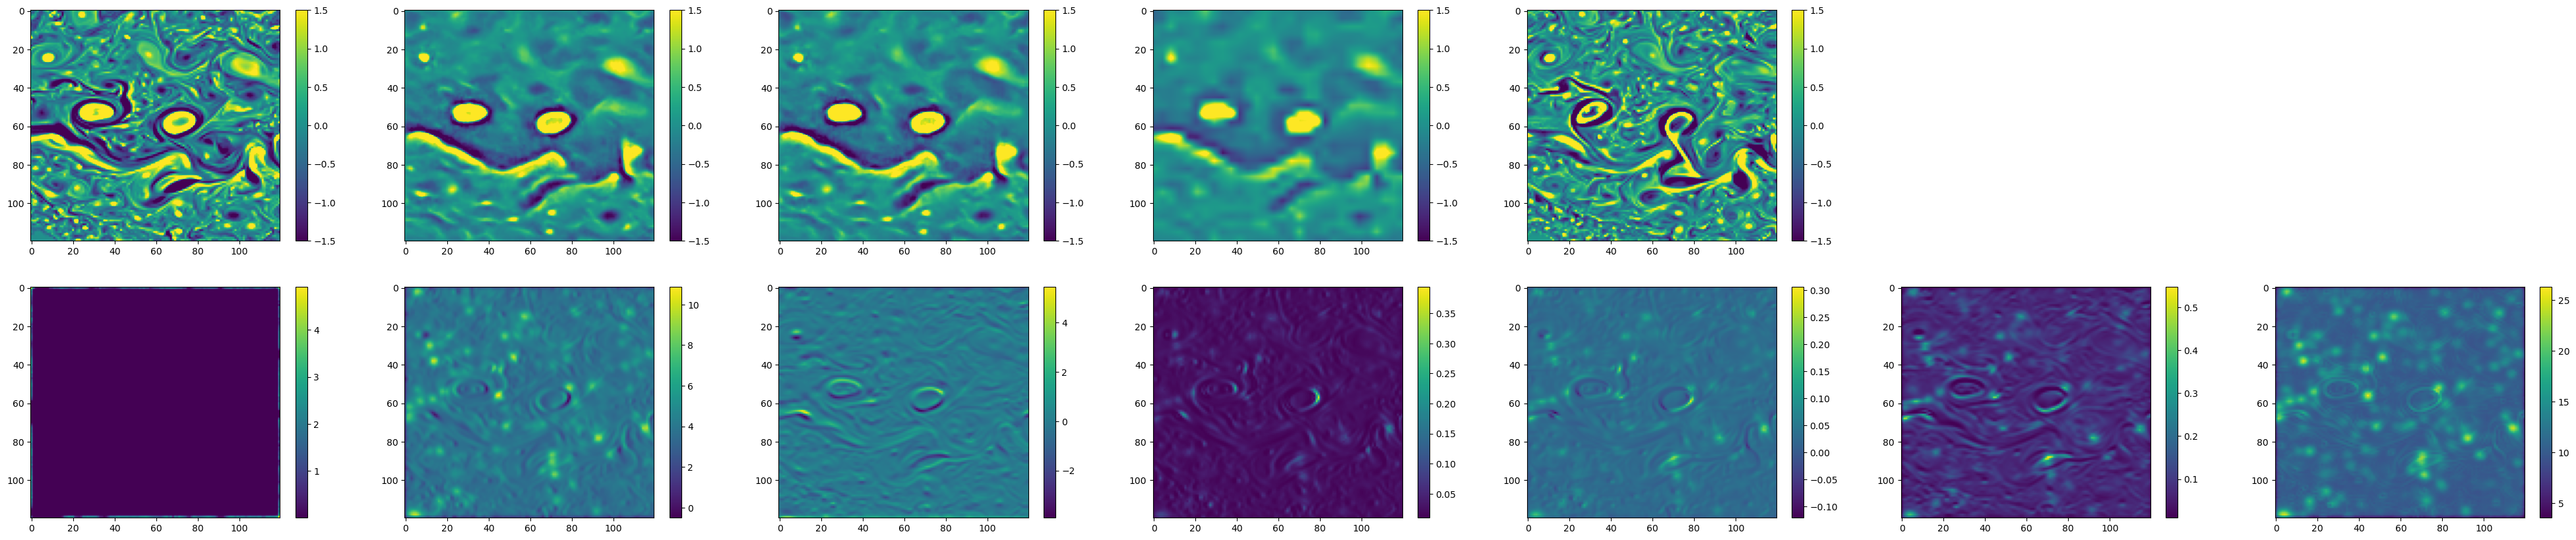

tensor(1.1666, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.2531, device='cuda:0', grad_fn=<MulBackward0>)


  2%|▊                                      | 1/50 [49:56<40:47:07, 2996.48s/it]


KeyboardInterrupt: 

In [12]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

n_epochs =  50#@param {'type':'integer'}
lr = 1e-3 #@param {'type':'number'}
    
optimizer = torch.optim.Adam(
        [
            {"params": solver.parameters(), "lr": lr},
            #{"params": solver2.parameters(), "lr": lr},
        ])

start = 50
reload = True
if reload:
    ckpt = torch.load('../ckpt/ckpt_spde_wonll_rzf=2_bigger_model_vorticity.pth', map_location=device)
    solver2.load_state_dict(ckpt)
    #ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2_bigger_model_vorticity.pth', map_location=device)
    #solver.load_state_dict(ckpt)


tqdm_epoch = tqdm(range(start,start+n_epochs))
solver.training = True
for epoch in tqdm_epoch:
  print(epoch)
  for batch in data_loader:
    batch = batch._replace(input=(batch.input).nan_to_num().to(device))
    batch = batch._replace(tgt=(batch.tgt).nan_to_num().to(device))
    loss, out = step(batch)
    optimizer.zero_grad() 
    if loss is not None:
        loss.backward()
    optimizer.step()
    print(loss)
    clear_output(wait=True)
    
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5)) 
  gt = ax1.imshow(batch.tgt[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(gt, ax=ax1)
  inp = ax2.imshow(batch.input[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(inp, ax=ax2)
  inp = ax3.imshow(out[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5) 
  plt.colorbar(inp, ax=ax3)
  plt.show()
    
  # Update the checkpoint after each epoch of training.
  if epoch<50: 
      torch.save(solver2.state_dict(), '../ckpt/ckpt_spde_wonll_rzf=2_bigger_model_vorticity.pth')
  else:
      torch.save(solver.state_dict(), '../ckpt/ckpt_spde_wnll_rzf=2_bigger_model_vorticity.pth')

# Test of the model

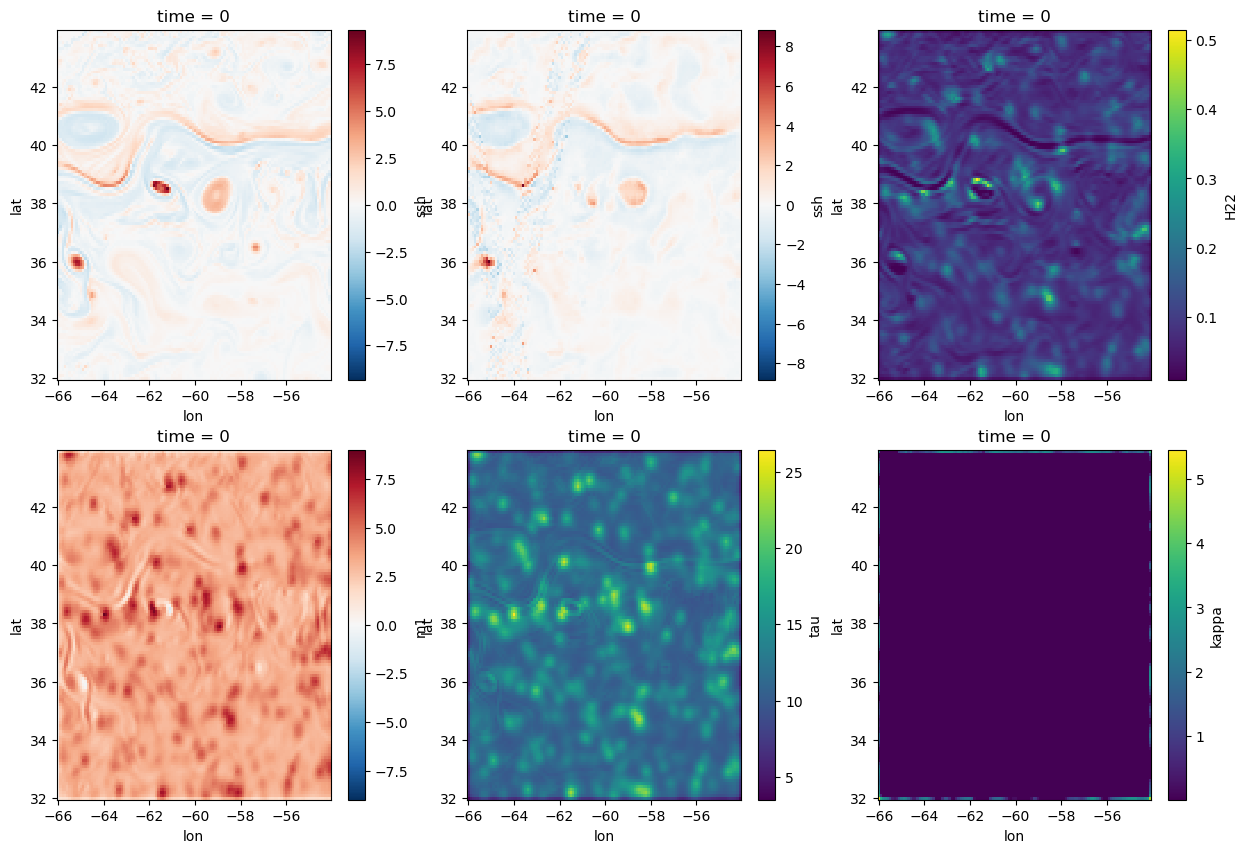

In [13]:
# test
from IPython.display import clear_output
ckpt = torch.load('../ckpt/ckpt_spde_wonll_rzf=2_bigger_model_vorticity.pth', map_location=device)
solver2.load_state_dict(ckpt)
ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2_bigger_model_vorticity.pth', map_location=device)
solver.load_state_dict(ckpt)

k = 2
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))

test_batch = test_batch._replace(input=test_batch.input.nan_to_num().to(device))
test_batch = test_batch._replace(tgt=test_batch.tgt.nan_to_num().to(device))

out = solver2(test_batch)
cropped_batch = crop_batch(test_batch)
# provide mu as coarse version of 4DVarNet outputs
mean = up(down(out))
cropped_batch = cropped_batch._replace(input=test_batch.tgt[:,crop_daw:-crop_daw,:,:].to(device)) #
_, theta = solver(batch=cropped_batch, 
                    #x_init=out[:,crop_daw:-crop_daw,:,:].detach(),
                    #mu=mean[:,crop_daw:-crop_daw,:,:].detach())
                    x_init=test_batch.tgt[:,crop_daw:-crop_daw,:,:].detach(),
                    mu=out[:,crop_daw:-crop_daw,:,:].detach())
out = out[:,crop_daw:-crop_daw,:,:]#

fig, axs= plt.subplots(2, 3, figsize=(15,10)) 
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[:,idt1,:,:].detach().cpu())},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.isel(time=0).plot(ax=axs[0,0])#(col='time')
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[:,idt2,:,:].detach().cpu())},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.isel(time=0).plot(ax=axs[0,1])#(col='time')
xr.Dataset(data_vars={'H22':(('time','lat','lon'),np.reshape(theta[2][:,1,1,:,idt2].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).H22.isel(time=0).plot(ax=axs[0,2])#(col='time')
xr.Dataset(data_vars={'m1':(('time','lat','lon'),np.reshape(theta[1][:,0,:,idt2].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).m1.isel(time=0).plot(ax=axs[1,0])#(col='time')
xr.Dataset(data_vars={'tau':(('time','lat','lon'),np.reshape(theta[3][:,0,:,idt2].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).tau.isel(time=0).plot(ax=axs[1,1])#(col='time')
xr.Dataset(data_vars={'kappa':(('time','lat','lon'),np.reshape(theta[0][:,0,:,idt2].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).kappa.isel(time=0).plot(ax=axs[1,2])#(col='time')
plt.show()

# Run simulations on the test case

In [14]:
from IPython.display import clear_output
from sksparse.cholmod import cholesky
import scipy 
import einops

def smooth(field):
    field = field.data
    m1 = torch.nn.AvgPool2d((2,2))
    m2 = torch.nn.Upsample(scale_factor=2, mode='bilinear')
    field = m2(m1(field))
    return field

def sparse_torch2scipy(A):
    B = scipy.sparse.csc_matrix((A.coalesce().values(),
                         A.coalesce().indices()),
                         shape=(A.size()[0],A.size()[0]),dtype=np.float64)
    return B

def run_simulation(i,tau,M,x,dx,dy,dt,n_init_run=10):
    nb_nodes = M.shape[0]
    regul = (tau*np.sqrt(dt))/(dx*dy)
    val = cupy.fromDlpack(to_dlpack(M.coalesce().values().data))
    ind = cupy.fromDlpack(to_dlpack(M.coalesce().indices().data))
    M_ = cupy_sp_csc_matrix((val,ind),shape=(M.size()[0],M.size()[0]))
    # if i==0: start stability run
    if i==0:
        xi = torch.randn(nb_nodes).to(device)
        for i in range(n_init_run):
            random = torch.randn(nb_nodes).to(device)
            RM = torch.mul(regul,random)+torch.flatten(xi)
            RM_ = cupy.fromDlpack(to_dlpack(RM))
            xi_ = cupy_spsolve(M_, RM_)
            xi = torch.flatten(from_dlpack(xi_.toDlpack())).to(device)
            #xi = torch.flatten(cupy_solve_sparse.apply(M,RM)).to(device)     
    else:
        random = torch.randn(nb_nodes).to(device)
        RM = torch.mul(regul,random)+torch.flatten(x[i-1])
        RM_ = cupy.fromDlpack(to_dlpack(RM))
        xi_ = cupy_spsolve(M_, RM_)
        xi = torch.flatten(from_dlpack(xi_.toDlpack())).to(device)
        #xi = torch.flatten(cupy_solve_sparse.apply(M,RM)).to(device)
    xi.requires_grad = True
    xi = torch.flatten(xi)
    x.append(xi)
    return x

n_b, n_t, n_y, n_x = out.shape
nb_nodes = n_x*n_y
dx = dy = dt = 1

# run n_simu non-conditional simulation
I = sparse_eye(nb_nodes)

def set_downsamp(nll,dw):
    nll.downsamp = dw
    nll.down = nn.AvgPool2d(nll.downsamp) if nll.downsamp is not None else nn.Identity()
    nll.up = (
            nn.UpsamplingBilinear2d(scale_factor=nll.downsamp)
            if nll.downsamp is not None
            else nn.Identity()
        )
    return nll
        
#solver.nll = set_downsamp(solver.nll,2)
if solver.nll.downsamp is not None:
    spde = Prior_SPDE([n_t,n_y//solver.nll.downsamp,n_x//solver.nll.downsamp],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")    
    theta[0],theta[1],theta[2],theta[3] = solver.nll.downsamp_params(theta[0],theta[1],theta[2],theta[3],
                                                         sp_dims=[n_y, n_x])
else:
    spde = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")
    
Q = spde(theta[0],theta[1],theta[2],theta[3],
         store_block_diag=False)

if solver.nll.downsamp is not None:
    theta[0],theta[1],theta[2],theta[3]  = solver.nll.upsamp_params(theta[0],theta[1],theta[2],theta[3] ,
                                                          sp_dims=[n_y//solver.nll.downsamp, 
                                                                   n_x//solver.nll.downsamp])

n_simu = 2
x_simu = []
type_simu="cov"
for ibatch in range(n_b):
    if type_simu=="seq":
        x_simu_ = []
        for _ in range(n_simu):
            simu = []
            for it in range(n_t):
                # A=solver.nll.operator_spde.fdm(
                A = DiffOperator_old(n_x,
                                     n_y,
                                     dx,
                                     dy,
                                     theta[1][ibatch,:,:,it],
                                     theta[2][ibatch,:,:,:,it],
                                     theta[0][ibatch,:,:,it])
                M = I+pow_diff_operator(A,pow=int(2*pow),sparse=True)
                simu = run_simulation(it,theta[3][ibatch,0,:,it],M,
                                                  simu,dx,dy,dt=1,n_init_run=10)
            x_simu_.append(torch.reshape(torch.stack(simu,dim=0),(n_t,n_y,n_x)))
        x_simu.append(torch.stack(x_simu_,dim=3))      
    else:
        Q_ = Q[ibatch].detach().cpu()
        Q_sp = sparse_torch2scipy(Q_)
        factor = cholesky(Q_sp,ordering_method='natural')
        if solver.nll.downsamp is not None:
            RM = factor.apply_P(torch.randn((nb_nodes//(solver.nll.downsamp**2))*n_t,n_simu))
        else:
            RM = factor.apply_P(torch.randn(nb_nodes*n_t,n_simu))
        x_simu_ = torch.FloatTensor(factor.solve_Lt(RM,
                                                    use_LDLt_decomposition=False)).to(device)
        if solver.nll.downsamp is not None:
            x_simu_ = torch.squeeze(torch.stack([solver.nll.up(torch.reshape(x_simu_[:,i],(1,n_t,n_x//solver.nll.downsamp,n_y//solver.nll.downsamp))) for i in range(n_simu)],dim=4),
                                dim=0)
        else:
            x_simu_ = torch.reshape(x_simu_,(n_t,n_x,n_y,n_simu))
        x_simu.append(x_simu_) 
x_simu = torch.stack(x_simu,dim=0).to(device)

#solver.nll = set_downsamp(solver.nll,None)

# interpolate the simulation based on LSTM-solver
x_simu_cond = []
x_itrp_simu = []
for i in range(n_simu):
    # !! S_NC = out + anomaly 
    inputs_simu = out.clone()  + smooth(x_simu[:,:,:,:,i])
    inputs_obs_simu = out.clone()  + smooth(x_simu[:,:,:,:,i])
    # increase size of simu_batch
    inputs_simu = torch.cat((einops.repeat(inputs_simu[:,0,:,:], 'b y x -> b t y x', t=int(crop_daw//2)),
                             inputs_simu,
                             einops.repeat(inputs_simu[:,-1,:,:], 'b y x -> b t y x', t=int(crop_daw//2))),dim=1)
    inputs_obs_simu = torch.cat((einops.repeat(inputs_simu[:,0,:,:], 'b y x -> b t y x', t=int(crop_daw//2)),
                             inputs_obs_simu,
                             einops.repeat(inputs_simu[:,-1,:,:], 'b y x -> b t y x', t=int(crop_daw//2))),dim=1)   
    mask = (test_batch.input!=0)
    inputs_obs_simu[~mask] = 0.
    simu_batch = test_batch
    simu_batch = simu_batch._replace(input=inputs_obs_simu)
    simu_batch = simu_batch._replace(tgt=inputs_simu)
    # itrp non-conditional simulations (solver 2 is enough)
    x_itrp_simu_ = solver2(simu_batch)
    x_itrp_simu_ = x_itrp_simu_[:,crop_daw:-crop_daw,:,:] 
    x_itrp_simu.append(x_itrp_simu_)
    # conditional simulations
    x_simu_cond_ = (simu_batch.tgt[:,crop_daw:-crop_daw,:,:] - x_itrp_simu_) + out
    x_simu_cond.append(x_simu_cond_)
x_itrp_simu = torch.stack(x_itrp_simu,dim=4).to(device)
x_simu_cond = torch.stack(x_simu_cond,dim=4).to(device)

CholmodNotPositiveDefiniteError: ../Supernodal/t_cholmod_super_numeric.c:911: matrix not positive definite (code 1)

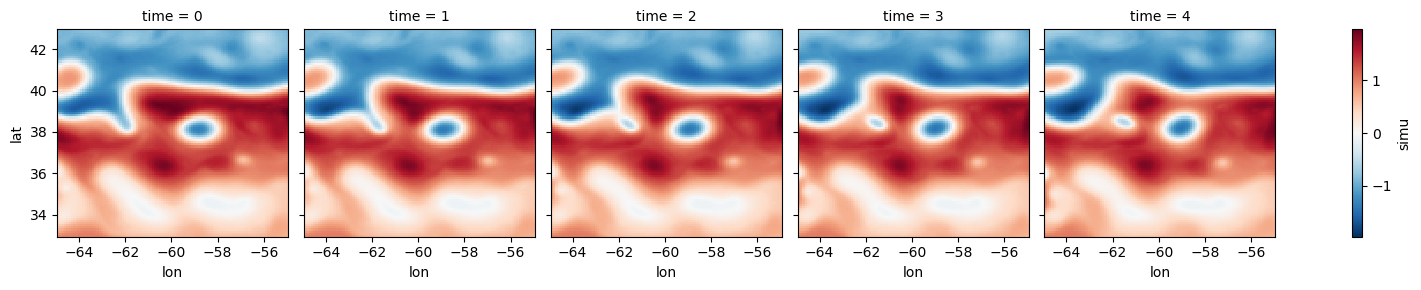

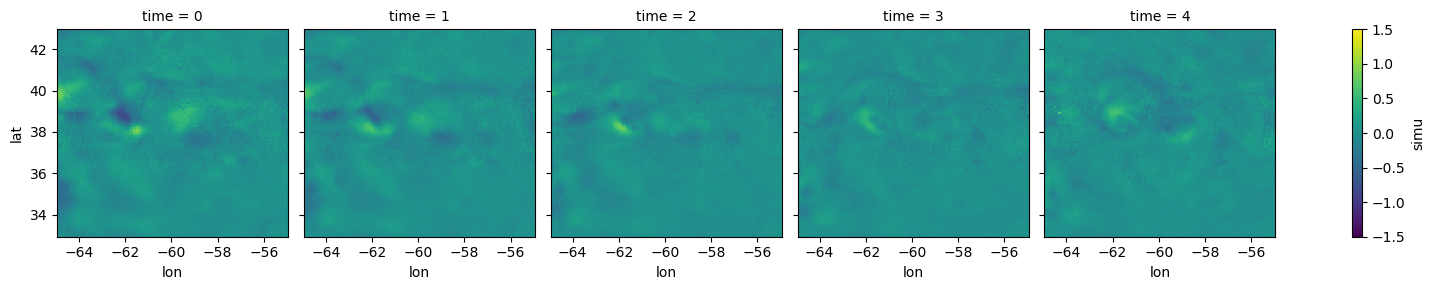

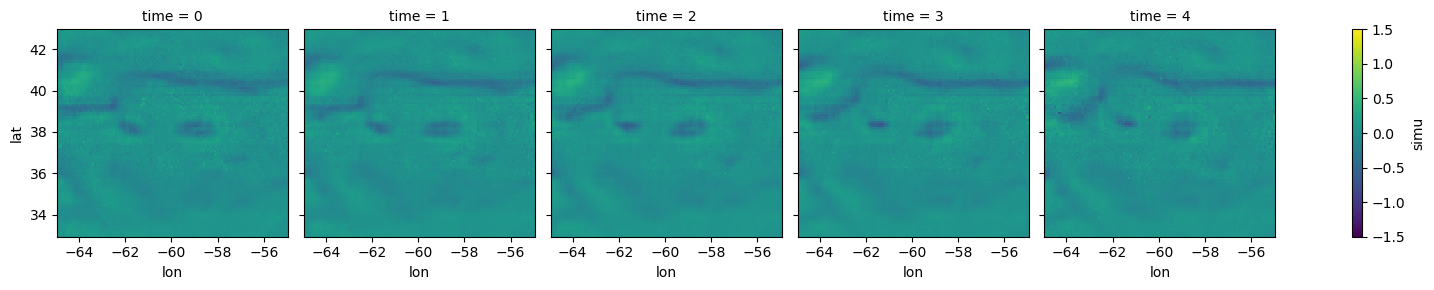

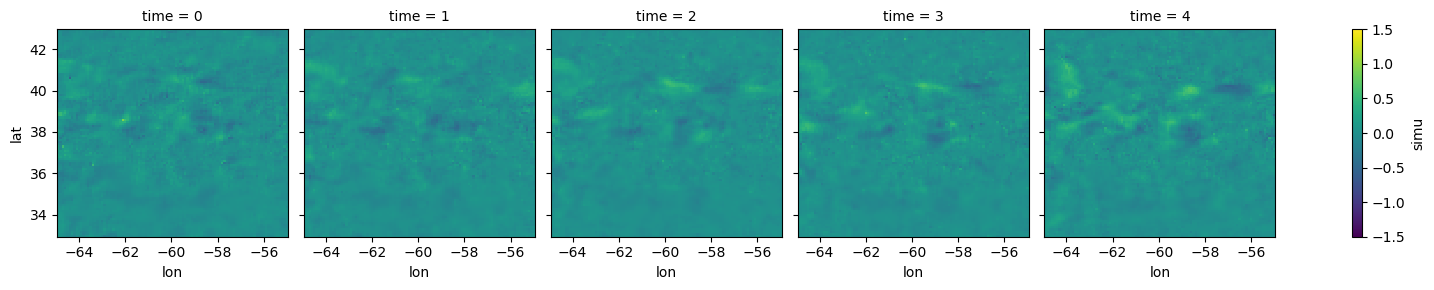

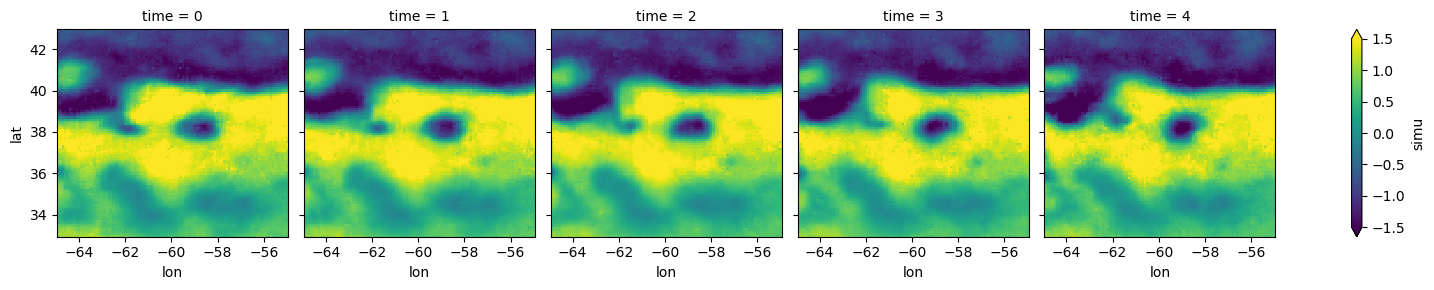

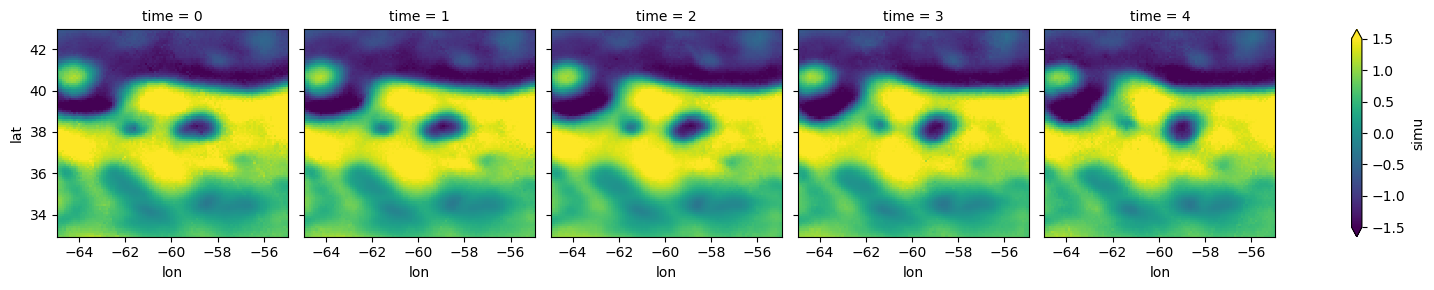

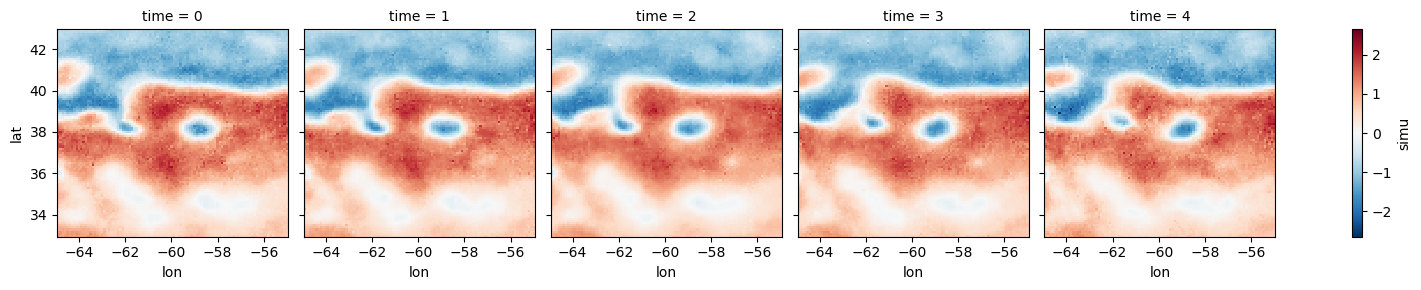

In [9]:
from IPython.display import clear_output

print(theta[3].shape)

# GT
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(test_batch.tgt[:1,crop_daw:-crop_daw,:,:].detach().cpu(),(5,120,120)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time')#,vmin=-1.5,vmax=1.5)
clear_output(wait=True)
plt.show()
# xt - x* (in the NLL training loss cost)
xr.Dataset(data_vars={'simu':(('time','lat','lon'),((test_batch.tgt[0,crop_daw:-crop_daw,:,:]-out)[0,:,:,:].detach().cpu()).numpy())},
           coords={'time':np.arange(15-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
# x* - xbar (in the NLL variational cost)
xr.Dataset(data_vars={'simu':(('time','lat','lon'),(out[0,:,:,:].detach().cpu()-up(down(out))[0,:,:,:].detach().cpu()).numpy())},
           coords={'time':np.arange(15-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:1,:,:,:,0].detach().cpu(),(15-2*crop_daw,120,120)))},
           coords={'time':np.arange(15-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),(crop_batch(simu_batch).tgt[0,:,:,:]).detach().cpu().numpy())},
           coords={'time':np.arange(15-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_itrp_simu[:1,:,:,:,0].detach().cpu(),(15-2*crop_daw,120,120)))},
           coords={'time':np.arange(15-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu_cond[:1,:,:,:,0].detach().cpu(),(15-2*crop_daw,120,120)))},
           coords={'time':np.arange(15-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.sel(lon=slice(-65,-55),lat=slice(33,43)).plot(col='time')#,vmin=-1.5,vmax=1.5)
plt.show()

# Run test dataset, output NetCDF and metrics

0/22
1/22
2/22
3/22
4/22
5/22
6/22
7/22
8/22
9/22
10/22
11/22
12/22
13/22
14/22
15/22
16/22
17/22
18/22
19/22
20/22
21/22


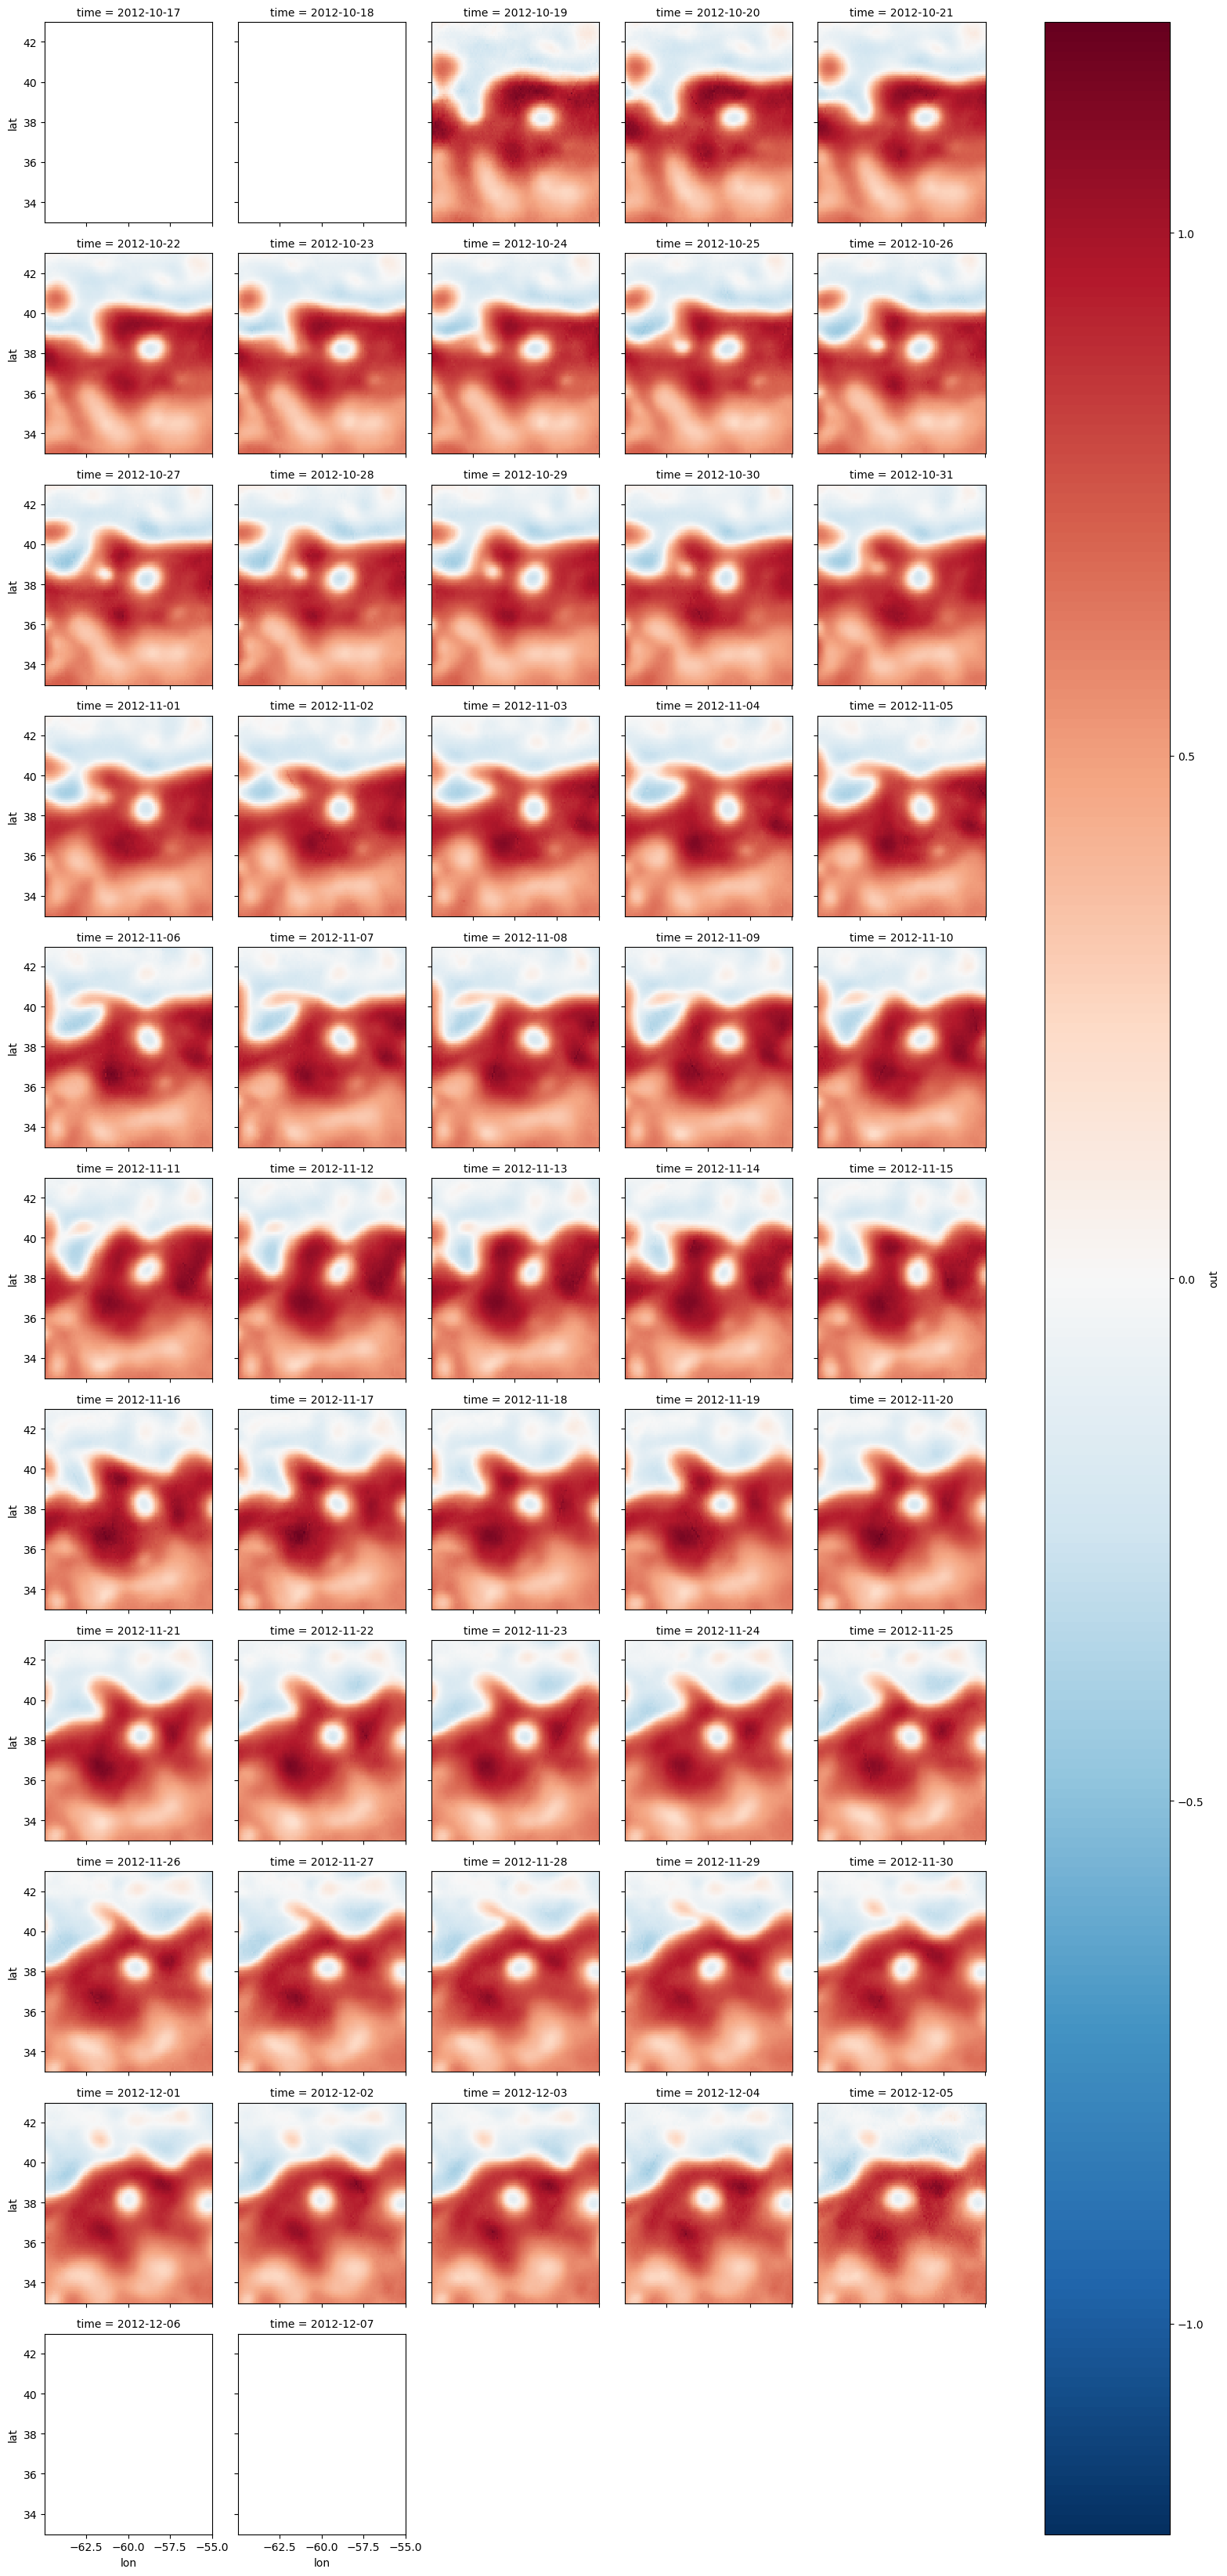

In [12]:
ckpt = torch.load('../ckpt/ckpt_spde_wonll_rzf=2_bigger_model_vorticity.pth', map_location=device)
solver2.load_state_dict(ckpt)
ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2_bigger_model_vorticity.pth', map_location=device)
solver.load_state_dict(ckpt)

test_data = []
test_simu = []
test_params = []

test_dataloader = datamodule.test_dataloader()

def test_quantities(self):
    return ['inp', 'tgt', 'out']

def test_simu_quantities(self):
    return ['sample_x', 'mx', 'sample_xy']

def test_params_quantities(self):
        return ['kappa', 'm1', 'm2', 'H11', 'H12', 'H21', 'H22', 'tau']


train_data = vort(xr.open_dataset('/DATASET/mbeauchamp/natl_gf_w_5nadirs_swot.nc'))
def norm_stats(train_data, variable='tgt'):
    return train_data.sel(variable=variable).pipe(lambda da: (da.mean().values.item(), da.std().values.item()))

m, s = norm_stats(train_data,variable='ssh')

if solver.nll.downsamp is not None:
    spde = Prior_SPDE([n_t,n_y//solver.nll.downsamp,n_x//solver.nll.downsamp],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")    
else:
    spde = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")    

n_simu = 100
factor = None
for k in range(len(test_dataloader)):
    print(str(k)+'/'+str(len(test_dataloader)))
    test_batch = next(itertools.islice(test_dataloader, k, None))
        
    test_batch_ = test_batch
    test_batch_ = test_batch_._replace(input=test_batch_.input.nan_to_num().to(device))
    test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.nan_to_num().to(device))
        
    # 4DVarNets scheme  
    out = solver2(test_batch_)
    cropped_batch = crop_batch(test_batch_)
    # provide mu as coarse version of 4DVarNet outputs
    mean = up(down(out))
    cropped_batch = cropped_batch._replace(input=test_batch_.tgt[:,crop_daw:-crop_daw,:,:].to(device)) # 
    _, theta = solver(batch=cropped_batch, 
                    #x_init=out[:,crop_daw:-crop_daw,:,:].detach(),
                    #mu=mean[:,crop_daw:-crop_daw,:,:].detach())
                    x_init=test_batch_.tgt[:,crop_daw:-crop_daw,:,:].detach(),
                    mu=out[:,crop_daw:-crop_daw,:,:].detach())
    out = out[:,crop_daw:-crop_daw,:,:]#
        
    n_b, n_t, n_y, n_x = out.shape
    nb_nodes = n_x*n_y
    dx = dy = dt = 1
    
    test_data.append(torch.stack(
        [
            crop_batch(test_batch_).input.cpu() * s + m,
            crop_batch(test_batch_).tgt.cpu() * s + m,
            out.squeeze(dim=-1).detach().cpu() * s + m,
        ],
        dim=1,
    ))
        
    # run n_simu non-conditional simulations
    if solver.nll.downsamp is not None: 
        theta[0],theta[1],theta[2],theta[3] = solver.nll.downsamp_params(theta[0],theta[1],theta[2],theta[3],
                                                         sp_dims=[n_y, n_x])
    Q = spde(theta[0],theta[1],theta[2],theta[3],
             store_block_diag=False)

    x_simu = []
    for ibatch in range(n_b):
        Q_ = Q[ibatch].detach().cpu()
        Q_sp = sparse_torch2scipy(Q_)
        if factor is None:
            factor = cholesky(Q_sp,ordering_method='natural')
        else:
            factor.cholesky_inplace(Q_sp)        
        if solver.nll.downsamp is not None:
            RM = factor.apply_P(torch.randn((nb_nodes//(solver.nll.downsamp**2))*n_t,n_simu))
        else:
            RM = factor.apply_P(torch.randn(nb_nodes*n_t,n_simu))
        x_simu_ = torch.FloatTensor(factor.solve_Lt(RM,
                                                    use_LDLt_decomposition=False)).to(device)
        if solver.nll.downsamp is not None:
            x_simu_ = torch.squeeze(torch.stack([solver.nll.up(torch.reshape(x_simu_[:,i],(1,n_t,n_x//solver.nll.downsamp,n_y//solver.nll.downsamp))) for i in range(n_simu)],dim=4),
                                dim=0)
        else:
            x_simu_ = torch.reshape(x_simu_,(n_t,n_x,n_y,n_simu))
        x_simu.append(x_simu_)
    x_simu = torch.stack(x_simu,dim=0).to(device)

    if solver.nll.downsamp is not None:
        theta[0],theta[1],theta[2],theta[3]  = solver.nll.upsamp_params(theta[0],theta[1],theta[2],theta[3] ,
                                                          sp_dims=[n_y//solver.nll.downsamp, 
                                                                   n_x//solver.nll.downsamp])
    
    # interpolate the simulation based on LSTM-solver
    x_simu_cond = []
    x_simu_itrp = []
    for i in range(n_simu):
        # !! S_NC = out + anomaly 
        inputs_simu = out.clone()  + smooth(x_simu[:,:,:,:,i])
        inputs_obs_simu = out.clone()  + smooth(x_simu[:,:,:,:,i])
        # increase size of simu_batch
        inputs_simu = torch.cat((einops.repeat(inputs_simu[:,0,:,:], 'b y x -> b t y x', t=int(crop_daw//2)),
                             inputs_simu,
                             einops.repeat(inputs_simu[:,-1,:,:], 'b y x -> b t y x', t=int(crop_daw//2))),dim=1)
        inputs_obs_simu = torch.cat((einops.repeat(inputs_simu[:,0,:,:], 'b y x -> b t y x', t=int(crop_daw//2)),
                             inputs_obs_simu,
                             einops.repeat(inputs_simu[:,-1,:,:], 'b y x -> b t y x', t=int(crop_daw//2))),dim=1)   
        mask = (test_batch_.input!=0)
        inputs_obs_simu[~mask] = 0.
        simu_batch = test_batch_
        simu_batch = simu_batch._replace(input=inputs_obs_simu)
        simu_batch = simu_batch._replace(tgt=inputs_simu)
        # itrp non-conditional simulations (solver 2 is enough)
        x_itrp_simu_ = solver2(simu_batch).detach()
        x_itrp_simu_ = x_itrp_simu_[:,crop_daw:-crop_daw,:,:] 
        x_simu_itrp.append(x_itrp_simu_)
        # conditional simulations
        x_simu_cond_ = (simu_batch.tgt[:,crop_daw:-crop_daw,:,:] - x_itrp_simu_) + out.detach()
        x_simu_cond.append(x_simu_cond_)
    x_simu_itrp = torch.stack(x_simu_itrp,dim=4).to(device).detach().cpu()                
    x_simu_cond = torch.stack(x_simu_cond,dim=4).to(device).detach().cpu() 
        
    test_simu.append(torch.stack(
            [
                x_simu.detach().cpu(),
                x_simu_itrp,
                x_simu_cond * s + m,
            ],
            dim=1,
        ))  
        
    # reshape parameters as maps
    kappa = torch.reshape(theta[0],(len(out),1,n_x,n_y,n_t))
    ma = torch.reshape(theta[1],(len(out),2,n_x,n_y,n_t))
    H = torch.reshape(theta[2],(len(out),2,2,n_x,n_y,n_t))
    tau = torch.reshape(theta[3],(len(out),1,n_x,n_y,n_t))
    kappa = torch.permute(kappa,(0,4,2,3,1))
    kappa = kappa[:,:,:,:,0]
    ma = torch.permute(ma,(0,4,2,3,1))
    m1 = ma[:,:,:,:,0]
    m2 = ma[:,:,:,:,1]
    H = torch.permute(H,(0,5,3,4,1,2))
    H11 = H[:,:,:,:,0,0]
    H12 = H[:,:,:,:,0,1]
    H21 = H[:,:,:,:,1,0]
    H22 = H[:,:,:,:,1,1]
    tau = torch.permute(tau,(0,4,2,3,1))
    tau = tau[:,:,:,:,0]
        
    test_params.append(torch.stack(
            [
                kappa.detach().cpu(),
                m1.detach().cpu(),
                m2.detach().cpu(),
                H11.detach().cpu(),
                H12.detach().cpu(),
                H21.detach().cpu(),
                H22.detach().cpu(),
                tau.detach().cpu()
            ],
            dim=1,
        ))       

# reconstruct mean
if isinstance(test_dataloader,list):
    rec_da = test_dataloader[0].dataset.reconstruct(
            test_data, rec_weight.cpu().numpy(), crop=crop_daw
    )
else:
    rec_da = test_dataloader.dataset.reconstruct(
            test_data, rec_weight.cpu().numpy(), crop=crop_daw
    )
rec_da = test_dataloader.dataset.reconstruct(test_data, rec_weight.cpu().numpy(), crop=crop_daw)
test_data = rec_da.assign_coords(
            dict(v0=test_quantities)
        ).to_dataset(dim='v0').isel(lon=slice(10,110),lat=slice(10,110))

# reconstruct parameters
if isinstance(test_dataloader,list):
    rec_params = test_dataloaders[0].dataset.reconstruct(
            test_params, rec_weight.cpu().numpy(), crop=crop_daw
    )
else:
    rec_params = test_dataloader.dataset.reconstruct(
                test_params, rec_weight.cpu().numpy(), crop=crop_daw
    )
rec_params = test_dataloader.dataset.reconstruct(
                test_params, rec_weight.cpu().numpy(), crop=crop_daw
             )
test_params = rec_params.assign_coords(
            dict(v0=test_params_quantities)
        ).to_dataset(dim='v0').isel(lon=slice(10,110),lat=slice(10,110))

# reconstruct simulations
rec_da_wsimu = []
for i in range(n_simu):
    if isinstance(test_dataloader,list):
        rec_simu = test_dataloader[0].dataset.reconstruct(
            [ts[:,:,:,:,:,i] for ts in test_simu], rec_weight.cpu().numpy(), crop=crop_daw
        )
    else:
        rec_simu = test_dataloader.dataset.reconstruct(
            [ts[:,:,:,:,:,i] for ts in test_simu], rec_weight.cpu().numpy(), crop=crop_daw
        )
    rec_simu = test_dataloader.dataset.reconstruct(
            [ts[:,:,:,:,:,i] for ts in test_simu], rec_weight.cpu().numpy(), crop=crop_daw
        )
    rec_da_wsimu.append(rec_simu)
if len(rec_da_wsimu)>1:
    test_simu = xr.concat(rec_da_wsimu, pd.Index(np.arange(n_simu), name='simu'))
else:
    test_simu = rec_da_wsimu[0]
    
test_simu = test_simu.assign_coords(
            dict(v0=test_simu_quantities)
        ).to_dataset(dim='v0').isel(lon=slice(10,110),lat=slice(10,110))

test_data = xr.merge([test_data,test_simu,test_params])
test_data.out.plot(col="time",col_wrap=5)

In [10]:
train_data = load_altimetry_data("/DATASET/mbeauchamp/natl_gf_w_5nadirs_swot.nc").sel(time=slice('2013-02-24', '2013-09-30',),
                                                                          lon=slice(lon_min, lon_max,),
                                                                          lat=slice(lat_min, lat_max,))

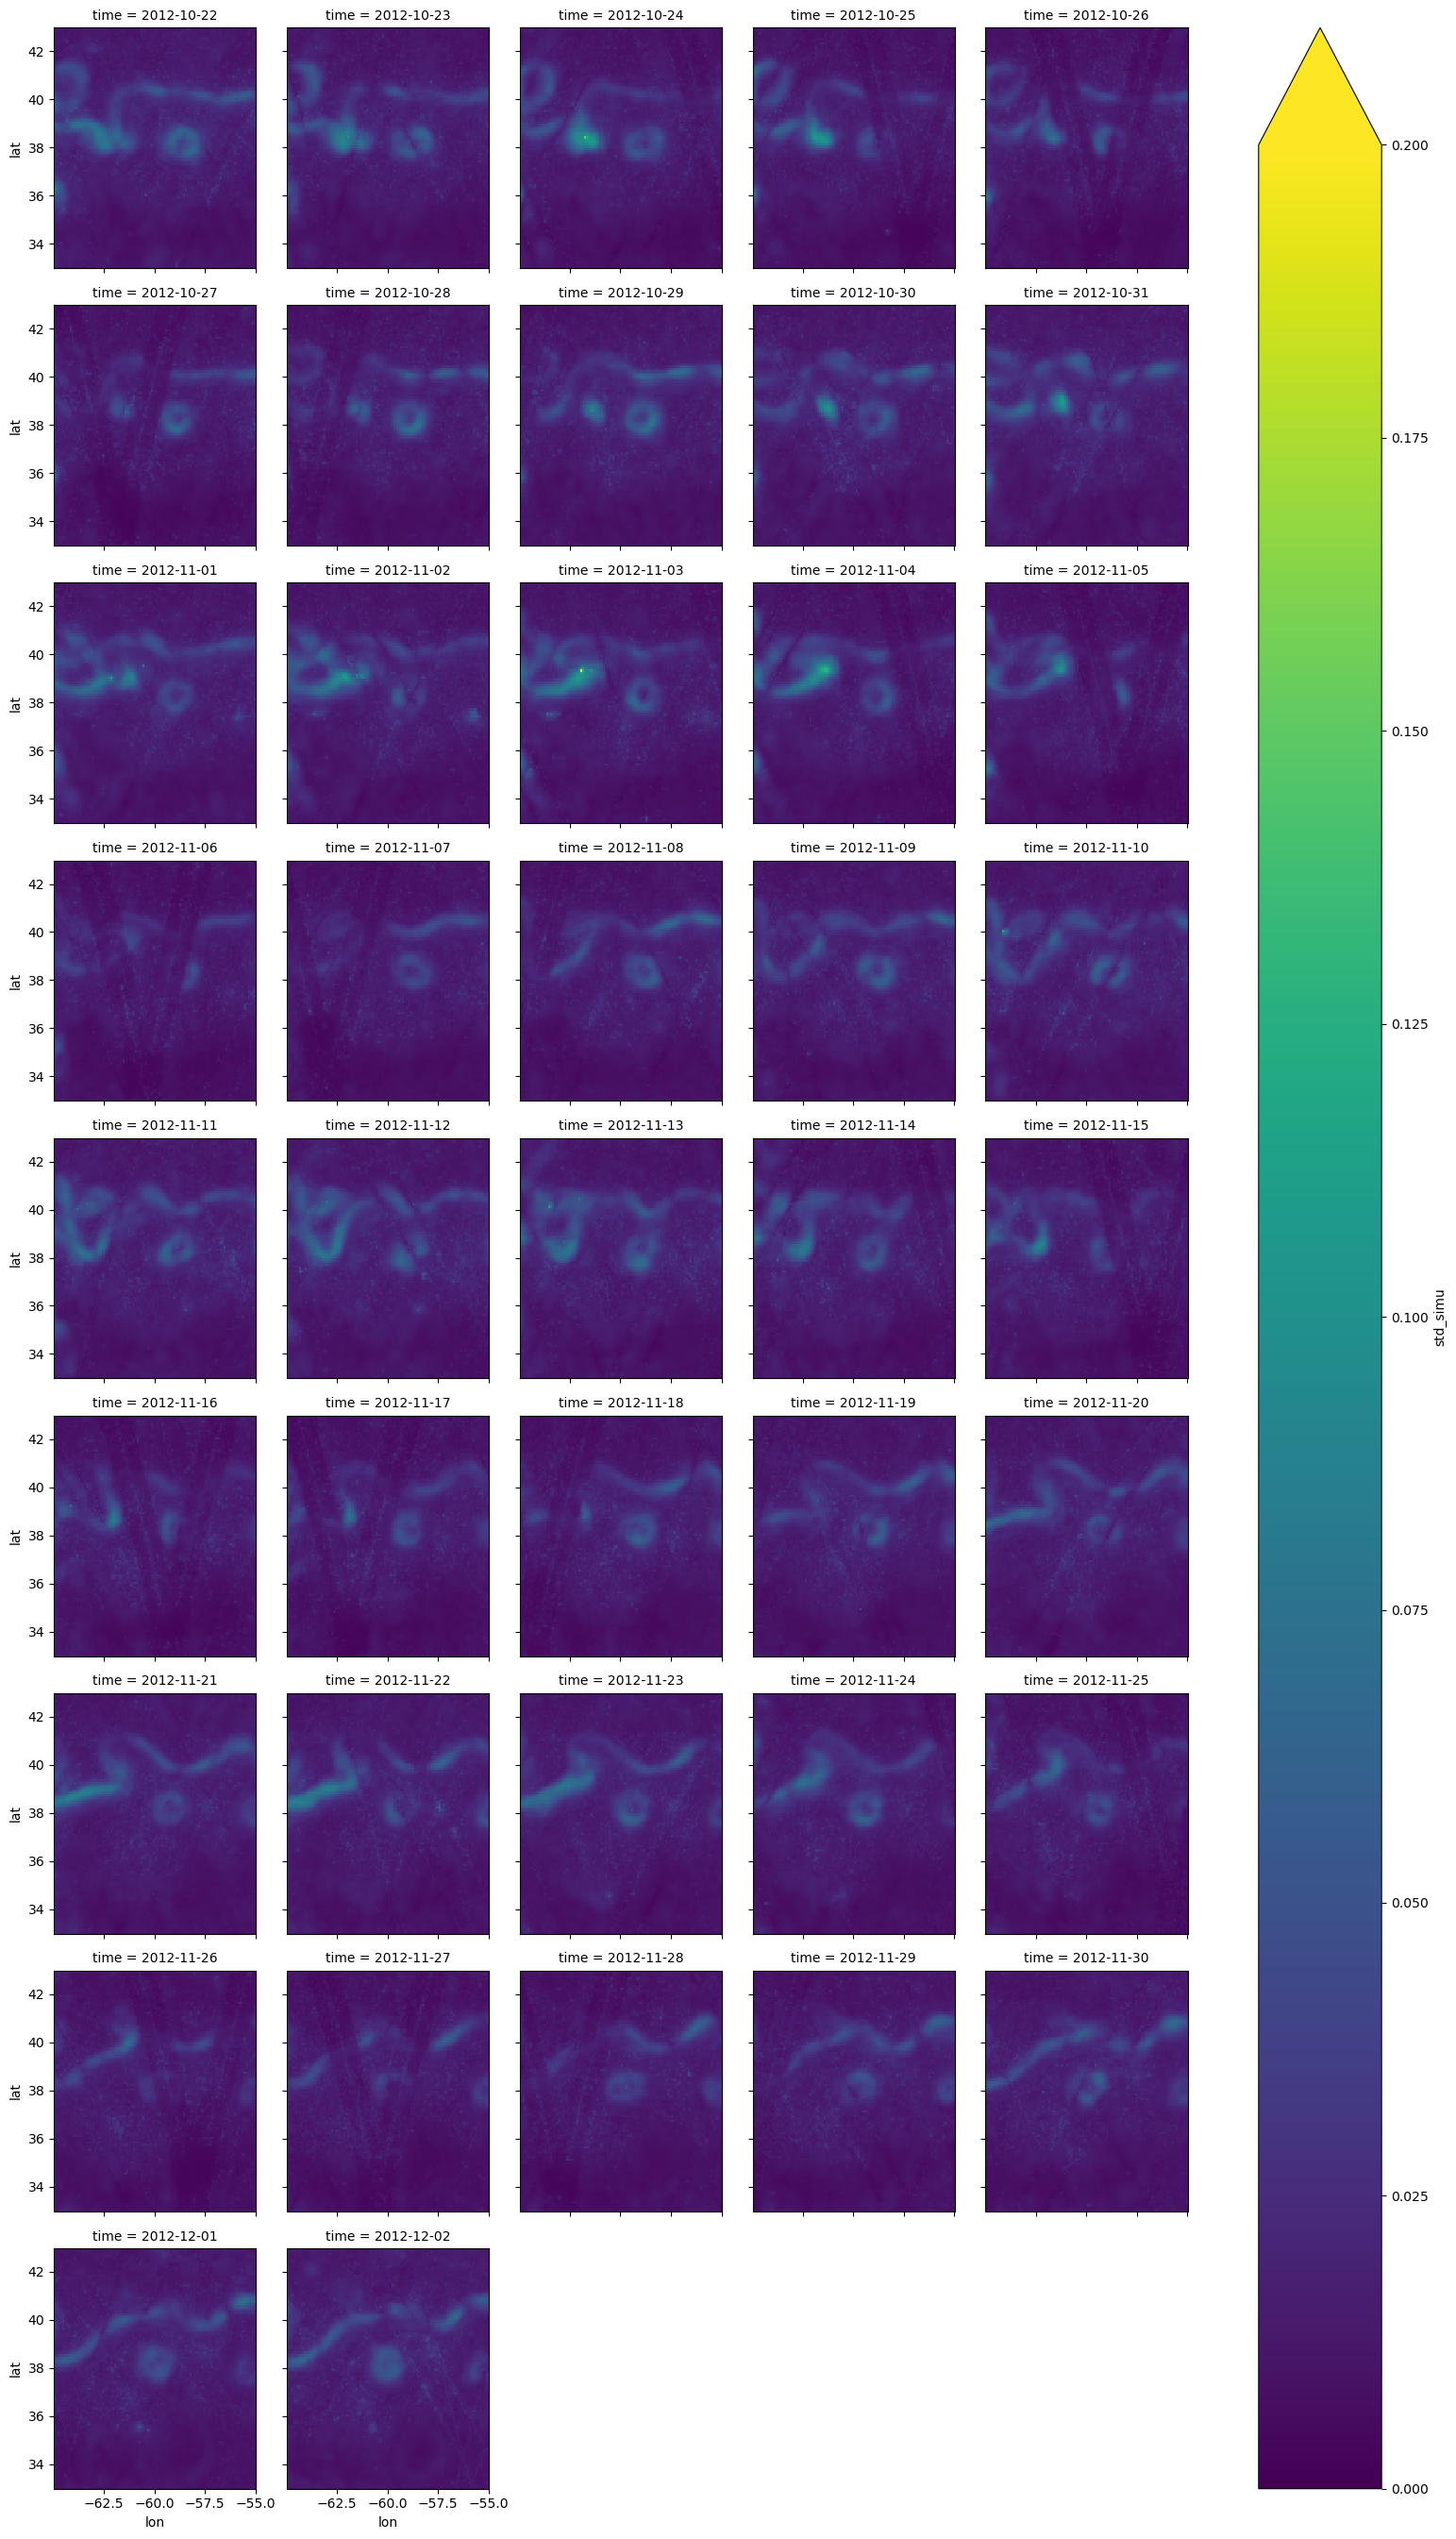

In [13]:
test_data = test_data.update({'std_simu':(('time','lat','lon'),test_data.sample_xy.std(dim='simu').values)})
test_data.std_simu.sel(time=slice('2012-10-22', '2012-12-02',)).plot(col="time",col_wrap=5,vmin=0,vmax=0.2)

In [16]:
from src.utils import rmse_based_scores_from_ds
from src.utils import psd_based_scores_from_ds
mu, sig = rmse_based_scores_from_ds(test_data.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable='out')
lx , lt = psd_based_scores_from_ds(test_data.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable='out')
print(mu,sig,lx,lt)

oi = xr.open_dataset("/DATASET/mbeauchamp/natl_4nadirs_swot.nc").sel(time=slice('2012-10-17', '2012-12-07',),
                                                                          lon=slice(lon_min, lon_max,),
                                                                          lat=slice(lat_min, lat_max,))
oi = oi.coarsen(lon=2,boundary='trim').mean(skipna=True).coarsen(lat=2,boundary='trim').mean(skipna=True)
test_data_woi = test_data.update({'oi':(('time','lat','lon'),oi.oi_ssh_mod.values[:,10:110,10:110])})
mu, sig = rmse_based_scores_from_ds(test_data_woi.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable='oi')
lx , lt = psd_based_scores_from_ds(test_data_woi.sel(time=slice('2012-10-22', '2012-12-02',)), ref_variable='tgt', study_variable='oi')
print(mu,sig,lx,lt)


0.94489 0.00992 1.224 9.374
0.9215 0.01694 1.205 13.893


In [15]:
test_data.sel(time=slice('2012-10-22', '2012-12-02',)).to_netcdf('/DATASET/mbeauchamp/xp_osse_rzf2_bigger_model_vorticity.nc')